In [3]:
import pandas as pd
import math
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib
import matplotlib.pyplot as plt             #visualisation
import os
from sklearn import preprocessing 
import plotly.express as px

%matplotlib inline     
sns.set(color_codes=True)

RQ3: Does the distance of an Airbnb property from the city’s 5 highest rated attractions (as per trip advisor) affect the likelihood of it being vacant?

In [4]:
path = './../London_data/'

listings = pd.read_csv(os.path.join(path, "listings.csv"))
listings.head(10)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,198258,https://www.airbnb.com/rooms/198258,20231210055232,2023-12-10,city scrape,Rental unit in Barking · ★4.74 · 1 bedroom · 1...,NaN,"I live in Barking town centre, at one time the...",https://a0.muscache.com/pictures/airflow/Hosti...,967537,...,4.88,4.45,4.68,NaN,f,1,0,1,0,0.27
1,33332,https://www.airbnb.com/rooms/33332,20231210055232,2023-12-10,city scrape,"Home in St Margaret's, Isleworth · ★4.40 · 1 ...",NaN,Peaceful and friendly.,https://a0.muscache.com/pictures/miso/Hosting-...,144444,...,4.53,4.68,4.26,NaN,f,2,0,2,0,0.12
2,42010,https://www.airbnb.com/rooms/42010,20231210055232,2023-12-10,city scrape,Home in East Finchley · ★4.88 · 1 bedroom · 1 ...,NaN,We have a unique cinema called the Phoenix whi...,https://a0.muscache.com/pictures/airflow/Hosti...,157884,...,4.95,4.73,4.87,NaN,t,2,0,2,0,3.45
3,284603,https://www.airbnb.com/rooms/284603,20231210055232,2023-12-11,previous scrape,Rental unit in London · ★4.83 · 1 bedroom · 1 ...,NaN,NaN,https://a0.muscache.com/pictures/3246231/8e9b1...,1481851,...,5.00,5.00,4.83,NaN,f,1,1,0,0,0.04
4,89870,https://www.airbnb.com/rooms/89870,20231210055232,2023-12-10,city scrape,Rental unit in London · ★4.65 · 1 bedroom · 1 ...,NaN,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,4.91,4.73,4.50,NaN,f,3,2,1,0,0.89
5,326146,https://www.airbnb.com/rooms/326146,20231210055232,2023-12-13,previous scrape,Rental unit in London · 1 bedroom · 1 bed,NaN,NaN,https://a0.muscache.com/pictures/3536712/9c7a9...,1667975,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
6,96052,https://www.airbnb.com/rooms/96052,20231210055232,2023-12-10,city scrape,Condo in London · ★4.82 · 2 bedrooms · 1 bed ·...,NaN,"Residential, quiet and green neighbourhood wit...",https://a0.muscache.com/pictures/airflow/Hosti...,448154,...,4.90,4.45,4.70,NaN,f,2,0,2,0,0.52
7,381467,https://www.airbnb.com/rooms/381467,20231210055232,2023-12-11,previous scrape,Rental unit in London · ★4.66 · 2 bedrooms · 2...,NaN,Peaceful and quite with beautiful tree lined s...,https://a0.muscache.com/pictures/4700556/fcce1...,1913410,...,4.82,4.88,4.64,NaN,f,1,1,0,0,1.86
8,390987,https://www.airbnb.com/rooms/390987,20231210055232,2023-12-10,city scrape,Home in London · ★4.73 · 8 bedrooms · 1 bed · ...,NaN,The neighbourhood is safe and many new cafes a...,https://a0.muscache.com/pictures/8841768/8130b...,1955537,...,4.83,4.75,4.75,NaN,f,3,0,3,0,0.09
9,394755,https://www.airbnb.com/rooms/394755,20231210055232,2023-12-11,previous scrape,Rental unit in London · 2 bedrooms · 2 beds · ...,NaN,NaN,https://a0.muscache.com/pictures/2b043814-44d7...,1973515,...,5.00,5.00,4.00,NaN,f,1,1,0,0,0.01


According to TripAdvisor, these are the top 5 highest rated attractions in London and their geographic position (https://www.tripadvisor.ca/Attractions-g186338-Activities-London_England.html):
1. Tower of London - (51.508530, -0.076132)
2. The British Museum - (51.518757, -0.126168)
3. London Eye - (51.503399, -0.119519)
4. National Gallery - (51.508972, -0.128794)
5. Tower Bridge - (51.505554, -0.075278)

In [5]:
# Here is the list of attractions in London and their coordinates
attract_coords = [("Tower_of_London", (51.508530, -0.076132)),("British_Museum", (51.518757, -0.126168)),("London_Eye", (51.503399, -0.119519)),("National_Gallery", (51.508972, -0.128794)),("Tower_Bridge", (51.505554, -0.075278))]

In [6]:
EARTH_RADIUS_KM = 6371

def to_radians(degrees):
    return degrees * math.pi / 180

def get_distance(lat1, lon1, lat2, lon2):
    r_lat1 = to_radians(lat1)
    r_lat2 = to_radians(lat2)
    d_lat = to_radians(lat2 - lat1)
    d_lon = to_radians(lon2 - lon1)
    a = ((math.sin(d_lat / 2) ** 2) +
         (math.cos(r_lat1) * math.cos(r_lat2) * (math.sin(d_lon / 2) ** 2)))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return EARTH_RADIUS_KM * c

# Feature Engineering

In [7]:
attraction_names = [attraction[0] for attraction in attract_coords]

# ----------------------------------------------------------------
# Feature engineering for "<Attraction_Name>_Distance" attributes
# ----------------------------------------------------------------
for attract_name, attract_coord in attract_coords:
    # Calculate distance for each attraction
    listings[attract_name + '_Distance'] = listings.apply(
        lambda row: get_distance(row['latitude'], row['longitude'], attract_coord[0], attract_coord[1]),
        axis=1)
    
# ----------------------------------------------------------------
# Feature engineering for "Nearest_Attraction_Name" attribute
# ----------------------------------------------------------------
def nearest_attraction_name(row):
    distances = [row[attraction + '_Distance'] for attraction in attraction_names]
    nearest_index = distances.index(min(distances))
    return attraction_names[nearest_index]

listings['Nearest_Attraction_Name'] = listings.apply(nearest_attraction_name, axis=1)

# ----------------------------------------------------------------
# Feature engineering for "Nearest_Attraction_Distance" attribute
# ----------------------------------------------------------------
def nearest_attraction_distance(row):
    distances = [row[attraction + '_Distance'] for attraction in attraction_names]
    nearest_index = distances.index(min(distances))
    return distances[nearest_index]

listings['Nearest_Attraction_Distance'] = listings.apply(nearest_attraction_distance, axis=1)

# ----------------------------------------------------------------
# Feature engineering for "Avg_Attractions_Distance" attribute
# ----------------------------------------------------------------
def avg_attraction_distance(row):
    distances = [row[attraction + '_Distance'] for attraction in attraction_names]
    return sum(distances) / len(distances)

listings['Avg_Attraction_Distance'] = listings.apply(avg_attraction_distance, axis=1)

# ----------------------------------------------------------------

print(listings)

                       id                                      listing_url  \
0                  198258              https://www.airbnb.com/rooms/198258   
1                   33332               https://www.airbnb.com/rooms/33332   
2                   42010               https://www.airbnb.com/rooms/42010   
3                  284603              https://www.airbnb.com/rooms/284603   
4                   89870               https://www.airbnb.com/rooms/89870   
...                   ...                                              ...   
91773  950589815013504257  https://www.airbnb.com/rooms/950589815013504257   
91774  951178246905249947  https://www.airbnb.com/rooms/951178246905249947   
91775  951188392382129035  https://www.airbnb.com/rooms/951188392382129035   
91776  951192793768996976  https://www.airbnb.com/rooms/951192793768996976   
91777  952607914901368427  https://www.airbnb.com/rooms/952607914901368427   

            scrape_id last_scraped           source  \
0      2

Mean distance to Tower_of_London is: 8.125 km


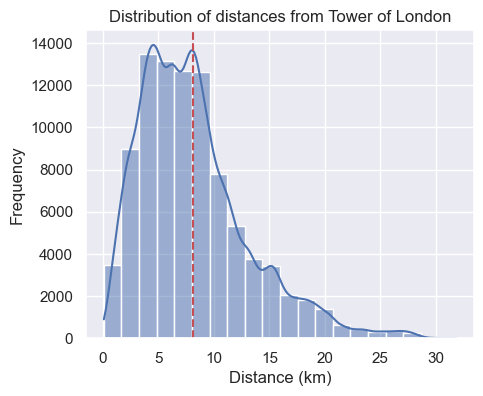

Mean distance to British_Museum is: 7.478 km


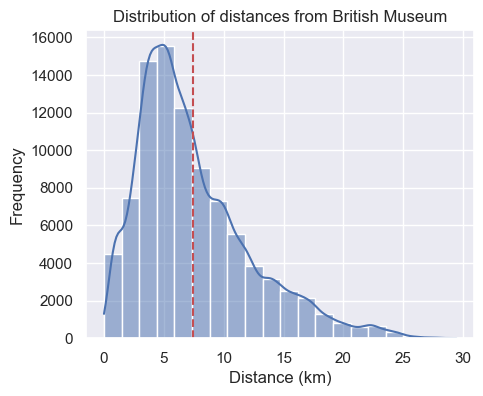

Mean distance to London_Eye is: 7.533 km


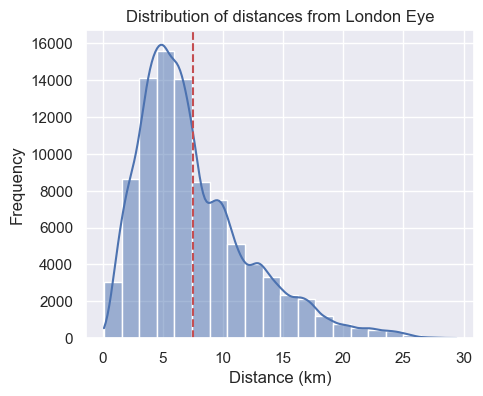

Mean distance to National_Gallery is: 7.453 km


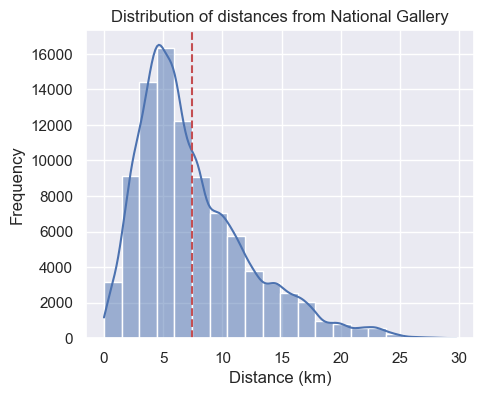

Mean distance to Tower_Bridge is: 8.176 km


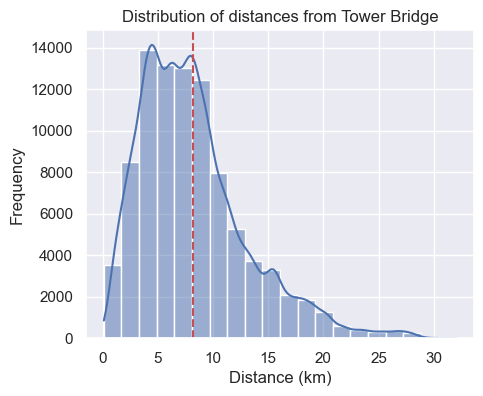

Mean nearest distance to an attraction is: 6.290 km


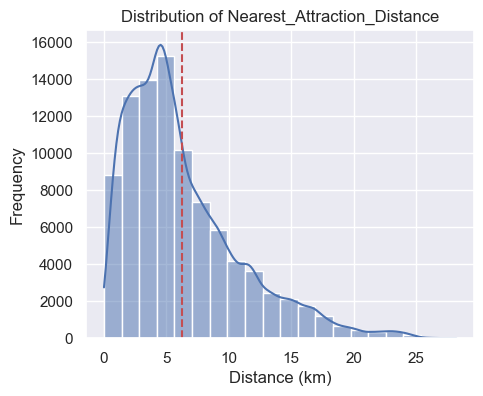

Mean average distance to an attraction is: 7.753 km


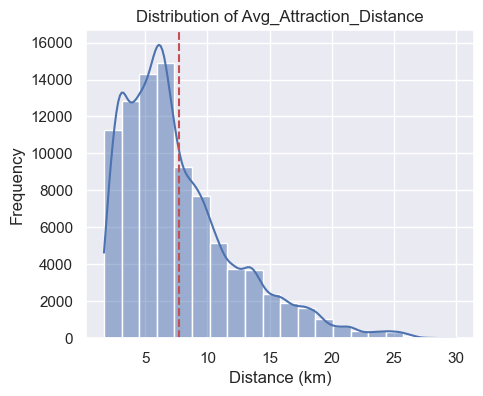

In [8]:
# Look at the distributions of each of the new features

# Distribution of <Attraction_Name>_Distance
for attract_name, _ in attract_coords:
    plt.figure(figsize=(5, 4))
    sns.histplot(listings[attract_name + '_Distance'], bins=20, kde=True)
    # Calculate mean distance
    mean_distance = listings[attract_name + '_Distance'].mean()
    print("Mean distance to {} is: {:.3f} km".format(attract_name, mean_distance))
    # Add mean as vertical line
    plt.axvline(mean_distance, color='r', linestyle='--', label=f'Mean: {mean_distance:.2f} km')
    plt.title(f'Distribution of distances from {attract_name.replace("_", " ")}')
    plt.xlabel('Distance (km)')
    plt.ylabel('Frequency')
    plt.show()

# Distribution of Nearest_Attraction_Distance
plt.figure(figsize=(5, 4))
sns.histplot(listings['Nearest_Attraction_Distance'], bins=20, kde=True)
# Calculate mean distance
mean_distance = listings['Nearest_Attraction_Distance'].mean()
print("Mean nearest distance to an attraction is: {:.3f} km".format(mean_distance))
# Add mean as vertical line
plt.axvline(mean_distance, color='r', linestyle='--', label=f'Mean: {mean_distance:.2f} km')
plt.title(f'Distribution of Nearest_Attraction_Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

# Distribution of Average_Attraction_Distance
plt.figure(figsize=(5, 4))
sns.histplot(listings['Avg_Attraction_Distance'], bins=20, kde=True)
# Calculate mean distance
mean_distance = listings['Avg_Attraction_Distance'].mean()
print("Mean average distance to an attraction is: {:.3f} km".format(mean_distance))
# Add mean as vertical line
plt.axvline(mean_distance, color='r', linestyle='--', label=f'Mean: {mean_distance:.2f} km')
plt.title(f'Distribution of Avg_Attraction_Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show() 

# Correlation Analysis

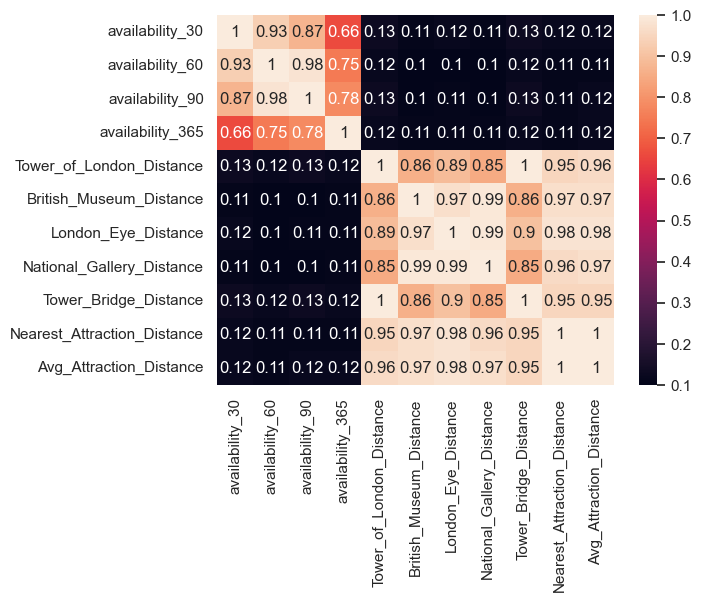

In [9]:
# Find the correlation between the distance to the top 5 attractions and the upcoming availability for a rental property.
avail_columns = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
dist_columns = ['Tower_of_London_Distance', 'British_Museum_Distance', 'London_Eye_Distance', 'National_Gallery_Distance', 'Tower_Bridge_Distance']
comb_columns = ['Nearest_Attraction_Distance', 'Avg_Attraction_Distance']

df_distances = listings[avail_columns + dist_columns + comb_columns]

corr = df_distances.corr(method='pearson').round(2)
corr_map = sns.heatmap(corr, annot=True)

# Creating a Model

In [12]:
# ----- Perform Correlation Analysis ----- #
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def train_test(model, train, test, avail_column):
    y_train = train[avail_column]    
    y_test = test[avail_column]
    x_train = train.drop([avail_column, 'train_or_test'], axis=1)
    print("x-data for training: ")
    print(x_train.head(10))
    x_test = test.drop([avail_column, 'train_or_test'], axis=1)

    # Evaluate performance with regular sale price
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    print("RMSE train: {}".format(rmse(y_train, y_pred_train)))
    print("RMSE test: {}".format(rmse(y_test, y_pred_test)))

    return y_pred_train, y_pred_test

def plot_results(df_results, title, avail_column):
    x_data = avail_column
    y_data = 'pred_' + avail_column
    fig_results = px.scatter(df_results, x=x_data, y=y_data, title=title, color='train_or_test')
    fig_results.add_shape(type='line', x0=0, y0=0, x1=df_results[x_data].max(), y1=df_results[x_data].max(),
    line=dict(color='red', dash='dash'), name='y=x')
    return fig_results

# ---- Create Model ----
model_GBR = GradientBoostingRegressor()
model_linear = LinearRegression()

# ---- Split into training/testing data ----
train, test = train_test_split(listings, test_size=0.2, shuffle=True)
train = train[comb_columns]
train.loc[:, 'train_or_test'] = 'Train'
test = test[comb_columns]
test.loc[:, 'train_or_test'] = 'Test'

# Create copies of the training and testing data or comparison with Model B
copy_train = train.copy()
copy_test = test.copy()

# ---- Model A ----
for avail_column in avail_columns:
    print('--- Plot of Comb Columns Versus {} ---'.format(avail_column))
    print(pd.concat([train, test, listings[avail_column]], ignore_index=True))
    y_pred_train, y_pred_test = train_test(model_linear, train, test, avail_column)
    train.loc[:, 'pred_' + avail_column] = y_pred_train
    test.loc[:, 'pred_' + avail_column] = y_pred_test
    results_A = pd.concat([train, test], ignore_index=True)
    fig_results_A = plot_results(results_A, "Comb Columns Versus "+avail_column, avail_column)
    fig_results_A.show()

--- Plot of Comb Columns Versus availability_30 ---
        Nearest_Attraction_Distance  Avg_Attraction_Distance train_or_test  \
0                         11.690797                13.521296         Train   
1                         19.024442                20.663167         Train   
2                          3.894086                 5.638699         Train   
3                          7.593593                 9.089743         Train   
4                          0.472851                 2.395200         Train   
...                             ...                      ...           ...   
183551                          NaN                      NaN           NaN   
183552                          NaN                      NaN           NaN   
183553                          NaN                      NaN           NaN   
183554                          NaN                      NaN           NaN   
183555                          NaN                      NaN           NaN   

           

KeyError: 'availability_30'